In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Diffusion model initialization

In [ ]:
### DIFFUSION MODEL ###
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange
from torch import einsum

def weight_init(shape, mode, fan_in, fan_out):
    if mode == 'xavier_uniform': return np.sqrt(6 / (fan_in + fan_out)) * (torch.rand(*shape) * 2 - 1)
    if mode == 'xavier_normal':  return np.sqrt(2 / (fan_in + fan_out)) * torch.randn(*shape)
    if mode == 'kaiming_uniform': return np.sqrt(3 / fan_in) * (torch.rand(*shape) * 2 - 1)
    if mode == 'kaiming_normal':  return np.sqrt(1 / fan_in) * torch.randn(*shape)
    raise ValueError(f'Invalid init mode "{mode}"')

class Conv2d(torch.nn.Module):
    def __init__(self,
        in_channels, out_channels, kernel, bias=True, up=False, down=False,
        resample_filter=[1,1], fused_resample=False, init_mode='kaiming_normal', init_weight=1, init_bias=0,
    ):
        assert not (up and down)
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.up = up
        self.down = down
        self.fused_resample = fused_resample
        init_kwargs = dict(mode=init_mode, fan_in=in_channels*kernel*kernel, fan_out=out_channels*kernel*kernel)
        self.weight = torch.nn.Parameter(weight_init([out_channels, in_channels, kernel, kernel], **init_kwargs) * init_weight) if kernel else None
        self.bias = torch.nn.Parameter(weight_init([out_channels], **init_kwargs) * init_bias) if kernel and bias else None
        f = torch.as_tensor(resample_filter, dtype=torch.float32)
        f = f.ger(f).unsqueeze(0).unsqueeze(1) / f.sum().square()
        self.register_buffer('resample_filter', f if up or down else None)

    def forward(self, x):
        w = self.weight.to(x.dtype) if self.weight is not None else None
        b = self.bias.to(x.dtype) if self.bias is not None else None
        f = self.resample_filter.to(x.dtype) if self.resample_filter is not None else None
        w_pad = w.shape[-1] // 2 if w is not None else 0
        f_pad = (f.shape[-1] - 1) // 2 if f is not None else 0

        if self.fused_resample and self.up and w is not None:
            x = torch.nn.functional.conv_transpose2d(x, f.mul(4).tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=max(f_pad - w_pad, 0))
            x = torch.nn.functional.conv2d(x, w, padding=max(w_pad - f_pad, 0))
        elif self.fused_resample and self.down and w is not None:
            x = torch.nn.functional.conv2d(x, w, padding=w_pad+f_pad)
            x = torch.nn.functional.conv2d(x, f.tile([self.out_channels, 1, 1, 1]), groups=self.out_channels, stride=2)
        else:
            if self.up:
                x = torch.nn.functional.conv_transpose2d(x, f.mul(4).tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=f_pad)
            if self.down:
                x = torch.nn.functional.conv2d(x, f.tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=f_pad)
            if w is not None:
                x = torch.nn.functional.conv2d(x, w, padding=w_pad)
        if b is not None:
            x = x.add_(b.reshape(1, -1, 1, 1))
        return x

class ChannelAttnBlock(nn.Module):
    def __init__(
        self,
        in_channels, # this is number of original channels + feature channels
        out_channels, # this should be the number of original channels
        channel_attn=True,
        reduction=16,
        groups=32,
        non_linearity="swish",
    ):
        super().__init__()
        self.channel_attn = channel_attn
        self.norm1 = nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=1e-6, affine=True)

        if non_linearity == "silu":
            self.act = nn.SiLU()
        else:
            self.act = nn.Swish()  # or any activation you prefer

        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1)

        # Squeeze-and-Excitation for channel attn
        self.se_channel_attn = SELayer(in_channels, reduction=reduction)

        # A second 1x1 conv to reduce channels (or keep same if you want)
        self.norm2 = nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=1e-6, affine=True)
        self.down_channel = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x, content_feat):
        """
        x:          [B, Cx, H, W]
        content_feat: [B, Cc, H, W] (multi-scale content feature)
        """
        # 1) Concat
        cat_feat = torch.cat([x, content_feat], dim=1)  # [B, Cx+Cc, H, W]

        # 2) Norm + act + 1x1
        h = self.norm1(cat_feat)
        h = self.act(h)
        h = self.conv1(h)

        # 3) Channel attention if enabled
        if self.channel_attn:
            h = self.se_channel_attn(h)
            # small skip/res
            h = h + cat_feat

        # 4) restore original feature map number
        h = self.norm2(h)
        h = self.act(h)
        h = self.down_channel(h)
        return h

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.SiLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class MCABlock(nn.Module):
    def __init__(
        self,
        emb_dim,
        in_channels,
        feature_channels,
        num_heads,
        reduction=16,
        groups=32,
        non_linearity='silu',
    ):
        super().__init__()
        self.channel_attn = ChannelAttnBlock(
            in_channels=in_channels+feature_channels,
            out_channels=in_channels,
            reduction=reduction,
            groups=groups,
            non_linearity=non_linearity
        )
        self.num_heads = num_heads
        self.gn1 = nn.GroupNorm(num_groups=groups, num_channels=in_channels)
        self.q = Conv2d(in_channels=in_channels, out_channels=in_channels, kernel=1)
        self.kv = nn.Linear(emb_dim, in_channels* 2)
        self.proj = Conv2d(in_channels=in_channels, out_channels=in_channels, kernel=1)
        assert in_channels % num_heads == 0, "Number of heads is incompatible with number of channels"


    def forward(self, x, content_feat, emb):
        x = self.channel_attn(x, content_feat)

        orig = x
        q = self.q(self.gn1(x)) # (b, C, H, W)
        kv = self.kv(emb) # (b, s, c)
        k, v = rearrange(kv, 'b s (n c) -> (b n) c s', n=self.num_heads).chunk(2, dim=1)
        q = rearrange(q, 'b (n c) h w -> (b n) c (h w)', n=self.num_heads)
        scores = einsum('bcq, bck -> bqk', q, k).mul(self.num_heads ** -0.5)
        scores = nn.functional.softmax(scores, dim=-1)
        x = einsum('bqk, bck -> bqc', scores, v)
        x = rearrange(x, '(b n) (h w) c -> b (n c) h w', n=self.num_heads, h=orig.shape[-2], w=orig.shape[-1])
        x = self.proj(x) + orig
        return x


class AttentionBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        num_heads,
        ngroups,
        feature_channels,
        emb_dim,
        reduction=16,
    ):
        super().__init__()
        self.num_heads = num_heads
        self.gn1 = nn.GroupNorm(num_groups=ngroups, num_channels=in_channels)
        self.qkv = Conv2d(in_channels=in_channels, out_channels=in_channels*3, kernel=1)
        self.proj = Conv2d(in_channels=in_channels, out_channels=in_channels, kernel=1)
        assert in_channels % num_heads == 0, "Number of heads is incompatible with number of channels"
        self.mca = MCABlock(emb_dim, in_channels, feature_channels, num_heads, reduction, ngroups)

    def forward(self, x, content_feat, emb):
        # first self attention block
        orig = x
        qkv = self.qkv(self.gn1(x)) # (b, Cx3, H, W)
        q, k, v = rearrange(qkv, 'b (n c) h w -> (b n) c (h w)', n=self.num_heads).chunk(3, dim=1)
        scores = einsum('bcq, bck -> bqk', q, k).mul(self.num_heads ** -0.5)
        scores = nn.functional.softmax(scores, dim=-1)
        x = einsum('bqk, bck -> bqc', scores, v)
        x = rearrange(x, '(b n) (h w) c -> b (n c) h w', n=self.num_heads, h=orig.shape[-2], w=orig.shape[-1])
        x = self.proj(x) + orig

        x = self.mca(x, content_feat, emb)
        return x

class UnetResBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        ngroups,
        t_emb_dim,
        c_emb_dim,
        dropout,
        feature_channels=None,
        down=False,
        up=False,
        attn=False,
        num_heads=1,
        resample_filter = [1, 1],
    ):
        super().__init__()
        assert not(up and down), "Res block can only upsample or downsample, cannot do both."
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.act = nn.SiLU()
        self.down = down
        self.up = up
        self.attn = attn
        self.gn1 = nn.GroupNorm(num_groups=ngroups, num_channels=in_channels)
        self.conv1 = Conv2d(in_channels, out_channels, kernel=3, up=up, down=down, resample_filter=resample_filter)
        self.gn2 = nn.GroupNorm(num_groups=ngroups, num_channels=out_channels)

        # time embedding injection
        self.emblinear = nn.Linear(t_emb_dim, out_channels * 2)

        self.dropout = dropout
        self.conv2 = Conv2d(out_channels, out_channels, kernel=3)
        self.skip = None
        if up or down or (in_channels != out_channels):
            self.skip = Conv2d(in_channels, out_channels, kernel=1, up=up, down=down, resample_filter=resample_filter)

        self.attn_block = AttentionBlock(
            out_channels,
            num_heads,
            ngroups,
            feature_channels,
            c_emb_dim,
            reduction=16,
        ) if attn else None

    def forward(self, x, t_emb, c_emb, content_feat=None):
        orig = x
        x = self.act(self.gn1(x))
        x = self.gn2(self.conv1(x))
        scale, shift = self.emblinear(t_emb).unsqueeze(2).unsqueeze(3).chunk(2, dim=1)
        x = self.act((scale+1)* x + shift)
        x = self.conv2(nn.functional.dropout(x, p=self.dropout, training=self.training))

        if self.skip:
            orig = self.skip(orig)

        x += orig
        if self.attn and self.attn_block is not None:
            x = self.attn_block(x, content_feat, c_emb)
        return x

class SinusoidalEmbedding(nn.Module):
    def __init__(self, d_model=128, max_time=10000):
        """
        Args:
            d_model (int): Dimension of the embedding vector.
            max_time (float): A large value to determine the frequency scaling.
        """
        super().__init__()
        self.d_model = d_model
        self.max_time = max_time

    def forward(self, timesteps):
        """
        Args:
            timesteps (torch.Tensor): A tensor of shape (batch_size,) representing time steps.

        Returns:
            torch.Tensor: Sinusoidal embeddings of shape (batch_size, d_model).
        """
        # Ensure timesteps is a float tensor
        timesteps = timesteps.float().unsqueeze(1)  # Shape: (batch_size, 1)

        # Compute the sinusoidal argument (frequencies scaled by max_time)
        denominator = torch.exp(torch.arange(0, self.d_model, 2, device=timesteps.device) * -(torch.log(torch.tensor(self.max_time)) / self.d_model))

        # Compute the embeddings: sin for even indices, cos for odd indices
        embeddings = torch.zeros((timesteps.size(0), self.d_model), device=timesteps.device)
        embeddings[:, 0::2] = torch.sin(timesteps * denominator)  # Apply sine to even indices
        embeddings[:, 1::2] = torch.cos(timesteps * denominator)  # Apply cosine to odd indices

        return embeddings

### UNET ###

class ColorMapUnet(nn.Module):
    def __init__(
        self,
        img_resolution = 32,
        in_channels = 3,                # Input color channels
        out_channels = 3,               # Output color channels
        text_dim = 512,                 # Text encoder embedding dimension
        ngroups = 16,

        model_channels = 128,           # Base number of channels per resolution
        channel_mult = [2, 2, 2],       # Channel multipler per resolution
        channel_mult_emb = 4,           # Multiplier on the time embeddings before feeding into network
        num_blocks = 4,                 # Number of res blocks per resolution
        attn_resolutions = [16],        # List of resolutions with attention
        feature_channels = {"16": 16},  # Number of feature channels in attention layers
        dropout = 0.10,                 # Dropout probability
    ):
        super().__init__()
        self.img_resolution = img_resolution
        self.model_channels = model_channels
        self.channel_mult = channel_mult

        # Time embedding
        time_embed_dim = model_channels * channel_mult_emb
        self.time_embedding = SinusoidalEmbedding(d_model=model_channels)
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Initial conv
        self.input_conv = Conv2d(in_channels, model_channels * channel_mult[0], kernel=3)

        # Encoder
        self.encoder = nn.ModuleList()
        channels = [model_channels * channel_mult[0]]


        for level, mult in enumerate(channel_mult):
            resolution = img_resolution >> level
            cin = model_channels * mult

            # Down blocks
            if level > 0:
                self.encoder.append(UnetResBlock(
                    in_channels=channels[-1],
                    out_channels=cin,
                    ngroups=ngroups,
                    t_emb_dim=time_embed_dim,
                    c_emb_dim=text_dim,
                    dropout=dropout,
                    down=True
                ))
                channels.append(cin)

            # Res blocks with optional attention
            for _ in range(num_blocks):
                self.encoder.append(UnetResBlock(
                    in_channels=channels[-1],
                    out_channels=cin,
                    ngroups=ngroups,
                    t_emb_dim=time_embed_dim,
                    c_emb_dim=text_dim,
                    dropout=dropout,
                    feature_channels=feature_channels.get(str(resolution)),
                    attn=(resolution in attn_resolutions)
                ))
                channels.append(cin)

        # Middle blocks
        self.middle = nn.ModuleList([
            UnetResBlock(
                in_channels=channels[-1],
                out_channels=channels[-1],
                ngroups=ngroups,
                t_emb_dim=time_embed_dim,
                c_emb_dim=text_dim,
                dropout=dropout,
                feature_channels=feature_channels.get(str(resolution)),
                attn=(resolution in attn_resolutions)
            ),
            UnetResBlock(
                in_channels=channels[-1],
                out_channels=channels[-1],
                ngroups=ngroups,
                t_emb_dim=time_embed_dim,
                c_emb_dim=text_dim,
                dropout=dropout,
            )
        ])

        # Decoder
        self.decoder = nn.ModuleList()
        for level, mult in reversed(list(enumerate(channel_mult))):
            resolution = img_resolution >> level

            # Res blocks with optional attention
            for _ in range(num_blocks + 1):
                self.decoder.append(UnetResBlock(
                    in_channels=channels[-1] + channels.pop(),  # Skip connection
                    out_channels=model_channels * mult,
                    ngroups=ngroups,
                    t_emb_dim=time_embed_dim,
                    c_emb_dim=text_dim,
                    dropout=dropout,
                    feature_channels=feature_channels.get(str(resolution)),
                    attn=(resolution in attn_resolutions)
                ))

            # Up blocks
            if level > 0:
                self.decoder.append(UnetResBlock(
                    in_channels=channels[-1],
                    out_channels=model_channels * channel_mult[level - 1],
                    ngroups=ngroups,
                    t_emb_dim=time_embed_dim,
                    c_emb_dim=text_dim,
                    dropout=dropout,
                    up=True
                ))

        # Output
        self.output = nn.Sequential(
            nn.GroupNorm(ngroups, model_channels * channel_mult[0]),
            nn.SiLU(),
            Conv2d(model_channels * channel_mult[0], out_channels, kernel=3)
        )
    def forward(self, x, timesteps, text_emb, content_features=None):
        # content_features will be a dict with {"dimension": feature_tensors}
        # Time embedding
        t_emb = self.time_embedding(timesteps)
        t_emb = self.time_embed(t_emb)

        # Initial conv
        h = self.input_conv(x)
        hs = [h]
        # Encoder
        for block in self.encoder:
            h = block(h, t_emb, text_emb, content_features.get(str(h.shape[-1]), None))
            hs.append(h)

        # Middle
        for block in self.middle:
            h = block(h, t_emb, text_emb, content_features.get(str(h.shape[-1]), None))
        # Decoder
        for block in self.decoder:
            if isinstance(block, UnetResBlock) and not (block.up or block.down):
                h = torch.cat([h, hs.pop()], dim=1)
            h = block(h, t_emb, text_emb, content_features.get(str(h.shape[-1]), None))

        # Output
        return self.output(h)

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

def initialize_vgg16_without_fc():
    """Initialize VGG16 without the linear (fully connected) layers."""
    vgg16 = models.vgg16(pretrained=True).requires_grad_(False)
    features = vgg16.features  # Only take the feature extraction part
    features.eval()
    return features

def extract_features_at_resolutions(vgg_features, input_tensor, resolutions):
    """
    Extract features from the given input tensor at specified resolutions.

    Args:
        vgg_features (nn.Module): The VGG16 feature extraction layers.
        input_tensor (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).
        resolutions (list): List of resolutions to extract features, e.g., [16, 8].

    Returns:
        dict: A dictionary where keys are resolutions and values are extracted feature tensors.
    """
    check = 0
    with torch.no_grad():
        outputs = {}
        x = input_tensor

        # Forward pass through the VGG16 feature layers
        for i, layer in enumerate(vgg_features):
            x = layer(x)

            # Check if the spatial resolution matches any target resolution
            if x.size(2) in resolutions:
                outputs[str(x.size(2))] = x.clone()
                check += 1

                if check == 2:
                    resolutions.remove(x.size(2))

            # Break early if all resolutions have been processed
            if not resolutions:
                break

    return outputs

### Text encoder initialization


In [ ]:
### TEXT ENCODER ###
from typing import List
from transformers import T5Tokenizer, T5EncoderModel
from einops import rearrange

# config
MAX_LENGTH = 77
T5_MODEL = "google/flan-t5-large"

tokenizer = T5Tokenizer.from_pretrained(T5_MODEL, model_max_length=MAX_LENGTH)
text_encoder = T5EncoderModel.from_pretrained(T5_MODEL)

def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def tokenize(texts: List[str]):
    device = next(text_encoder.parameters()).device
    inputs = tokenizer(
        texts,
        return_tensors = "pt",
        padding = "max_length",
        max_length = MAX_LENGTH,
        truncation = True
    ).to(device)

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    return inputs, attention_mask

def encode_tokenized_text(token_ids, attn_mask=None, pad_id=None):
    assert exists(attn_mask) or exists(pad_id)
    attn_mask = default(attn_mask, lambda: (token_ids != pad_id).long())
    text_encoder.eval()
    with torch.no_grad():
        output = text_encoder(input_ids=token_ids, attention_mask=attn_mask)
        output = output.last_hidden_state.detach()

    attn_mask = attn_mask.bool()
    output = output.masked_fill(~rearrange(attn_mask, '... -> ... 1'), 0.) # just force all embeddings that is padding to be equal to 0.
    return output

def encode_text(texts: List[str], return_attn_mask = False):
    inputs, attn_mask = tokenize(texts)
    output = encode_tokenized_text(inputs["input_ids"], attn_mask=attn_mask, pad_id=tokenizer.pad_token_id)
    if return_attn_mask:
        attn_mask = attn_mask.bool()
        return output, attn_mask
    return output


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

### Inference script

loading model...


<ipython-input-9-fa8d895fe623>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth))


model loaded!


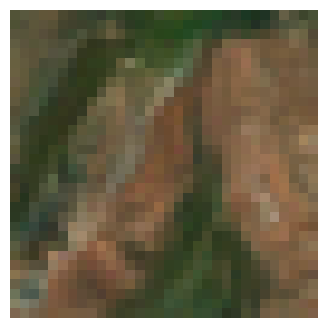

In [ ]:
import torch
import numpy as np
import random

seed_value = 42

# Set seeds for reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


from PIL import Image
import torchvision.transforms as transforms

### model path
model_pth = "/path/to/25epoch_ema_70m.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

### For 50 million params set num_blocks = 3, for 70 mil set num_blocks = 4
model = ColorMapUnet(
    img_resolution = 32,
    in_channels = 3,
    out_channels = 3,
    text_dim = 1024,
    ngroups = 16,
    model_channels = 128,
    channel_mult = [2, 2, 2],
    channel_mult_emb = 4,
    num_blocks = 4,
    attn_resolutions = [16],
    feature_channels = {"16": 128},
    dropout = 0.10,
)
print("loading model...")
model.load_state_dict(torch.load(model_pth))
print("model loaded!")

vgg = initialize_vgg16_without_fc()
model.to(device)
vgg.to(device)

### Edit DEM path based on which dem you want to use

!cp /content/drive/MyDrive/path/to/dem32image.png /content/

dem_pth = "/content/dem32image.png"


dem_img = Image.open(dem_pth).convert("L")
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # normalize range from [0,1] to [-1,1] for model
])
dem_img = transform(dem_img)
c_feat = dem_img.repeat(1, 3, 1, 1).to(device)

### Write the text conditioning string
text_conditioning = "Green hills on left, brown mountains above, dark green forests below."

# convert to the embeddings of length 1024
text_conditioning = encode_text([text_conditioning]).to(device)
features = extract_features_at_resolutions(vgg, c_feat, [16])

# change the CFG based on what you want
cfg_scale = 8

steps = 100

with torch.no_grad():
    xt = torch.randn(1, 3, 32, 32).to(device)
    for i, t_val in enumerate(torch.linspace(1, 0, steps)):
        t_batch = torch.full((1,), t_val, device=device)
        cond_out = model(xt, t_batch, text_conditioning, features)
        uncond_text = torch.zeros_like(text_conditioning).to(device)
        uncond_out = model(xt, t_batch, uncond_text, features)

        guided_out = uncond_out + cfg_scale * (cond_out - uncond_out)
        # Flow matching update:
        xt = xt + (1 / steps) * guided_out

import matplotlib.pyplot as plt
final_image = (torch.clamp(xt.squeeze(0), -1, 1).detach().cpu().numpy() + 1) / 2.0

# Transpose from (C, H, W) to (H, W, C) for visualization
final_image = final_image.transpose(1, 2, 0)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(final_image)
plt.axis('off')  # Hide axes
plt.show()